Testing how many points from prior are non zero

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import corner as corner
from gwpopulation.utils import powerlaw
import glob
import corner as corner
import os

/opt/conda/igwn-py310-20240410/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
from variable_qmin import two_component_primary_mass_ratio_powerlaw_m2min

In [ ]:
#points from prior
no_points = 10000
dataset={'mass_1':60., 'mass_ratio':0.9} 
alpha = np.random.rand(no_points)*16 - 4
beta = np.random.rand(no_points)*9 - 2
gamma = np.random.rand(no_points)*34+1
mmin = np.random.rand(no_points)*4 + 2
mmax = np.random.rand(no_points)*38 + 62
lam = np.random.rand(no_points)
mpp  = np.random.rand(no_points)*30 + 20
sigpp = np.random.rand(no_points)*9 +1

In [8]:
likelihoods = two_component_primary_mass_ratio_powerlaw_m2min(dataset, alpha, beta, gamma, mmin, mmax, lam, mpp, sigpp)

In [9]:
len(likelihoods[likelihoods>0])/len(likelihoods)

0.9839

In [3]:
from variable_qmin import parabola_m2min_allgammazeta

In [20]:
gamma = np.random.rand(no_points)*2-1
zeta = np.random.rand(no_points)*0.017094017094*2-0.017094017094

In [23]:
likelihoods = parabola_m2min_allgammazeta(dataset, alpha, beta, gamma, zeta, mmin, mmax, lam,\
                                          mpp, sigpp)

In [24]:
len(likelihoods[likelihoods>0])/len(likelihoods)

0.3862

Testing drawing from a conditional prior

In [2]:
import variable_qmin
from bilby.core.prior import (
    Prior, PriorDict, ConditionalPriorDict,
    Uniform, ConditionalUniform, Constraint, 
)
import corner as corner
import numpy as np
import matplotlib.pyplot as plt

In [3]:
gamma = Uniform(minimum=-0.5, maximum=0.5, name='gamma', latex_label='$\\gamma_{q}$')
mmax = Uniform(minimum=62, maximum=100, name='mmax', latex_label='$m_{\\max}$')
mmin = Uniform(minimum=2, maximum=6, name='mmin', latex_label='$m_{\\min}$')

prior = variable_qmin.zeta_with_conditional(mmax,mmin)

In [9]:
prior_samps = prior.sample(3000)

In [16]:
prior_samps

{'gamma': array([-0.07681045, -0.21067006, -0.150237  , ..., -0.45624516,
        -0.30181063,  0.01099083]),
 'mmax': array([94.3447544 , 82.50607794, 95.23672091, ..., 87.47875361,
        90.41337758, 84.25907464]),
 'mmin': array([3.7184841 , 3.51005706, 5.81392833, ..., 5.63405547, 3.12005055,
        3.40744756]),
 'zeta': array([0.00207869, 0.00423949, 0.00227893, ..., 0.01234023, 0.01315379,
        0.01068842])}

In [22]:
def parabola_m2min_m1(mass1, mmax, mmin, gamma, zeta):
    m2min = mmin + gamma*(mass1 - mmin) + zeta * (mass1 - mmin)**2
    m2min[m2min>mmax]=np.nan
    return m2min

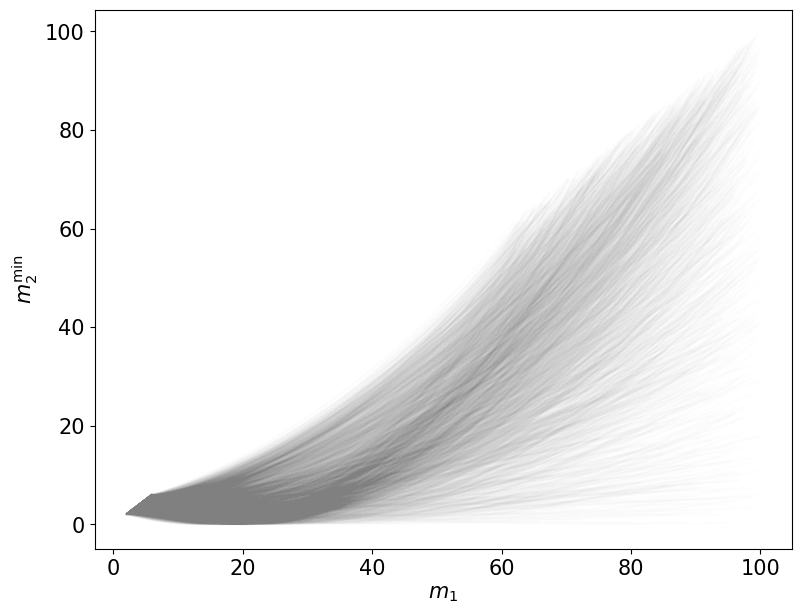

In [23]:

plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (9,7)

for i in range(3000):
    mass1_parabola = np.linspace(prior_samps['mmin'][i], prior_samps['mmax'][i],1000)
    m2min_parabola = parabola_m2min_m1(mass1_parabola, prior_samps['mmax'][i], prior_samps['mmin'][i],\
                     prior_samps['gamma'][i], prior_samps['zeta'][i])
    plt.plot(mass1_parabola, m2min_parabola, color='grey', alpha=0.01)
   
plt.xlabel(r'$m_1$')
plt.ylabel(r'$m_2^{\rm min}$')
plt.savefig('inference/paper_plots/parabola_modellines_prior.pdf')

In [24]:
mass1_arry = np.linspace(2., 100.,1000)
m2min_parabola = [parabola_m2min_m1(mass1_arry, prior_samps['mmax'][i], prior_samps['mmin'][i],\
                     prior_samps['gamma'][i], prior_samps['zeta'][i]) for i in range(3000)]

Text(0, 0.5, '$m_2^{\\rm min} ~/ \\mathrm{M}_{\\odot}$')

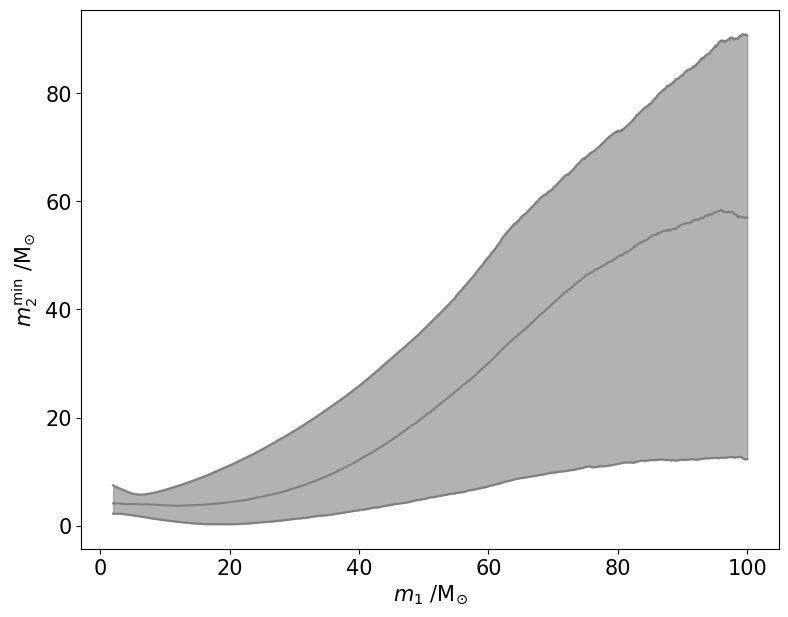

In [25]:
plt.rcParams["figure.figsize"] = (9,7)
plt.rcParams.update({'font.size': 15})
plt.plot(mass1_arry,np.nanpercentile(m2min_parabola, q=5, axis=0), color='grey')
plt.plot(mass1_arry,np.nanpercentile(m2min_parabola, q=95, axis=0), color='grey')
plt.plot(mass1_arry,np.nanmedian(m2min_parabola, axis=0), color='grey')
plt.fill_between(mass1_arry, np.nanpercentile(m2min_parabola, q=5, axis=0)\
                 ,np.nanpercentile(m2min_parabola, q=95, axis=0), color='grey', alpha=0.6)

plt.xlabel(r'$m_1 ~/ \mathrm{M}_{\odot}$')
plt.ylabel(r'$m_2^{\rm min} ~/ \mathrm{M}_{\odot}$')

In [26]:
np.save('parabola_prior_percentiles/5th_percentile.npy', np.nanpercentile(m2min_parabola, q=5, axis=0))
np.save('parabola_prior_percentiles/95th_percentile.npy', np.nanpercentile(m2min_parabola, q=95, axis=0))
np.save('parabola_prior_percentiles/med_percentile.npy', np.nanpercentile(m2min_parabola, q=50, axis=0))

In [20]:
mass1_parabola = np.linspace(5., 96.,1000)
min_m2min=[]
for zeta in np.linspace(0.,0.02,10000):
    m2min_parabola = parabola_m2min_m1(mass1_parabola, 96., 5.,\
                     -0.4, zeta)
    min_m2min.append(np.min(m2min_parabola))

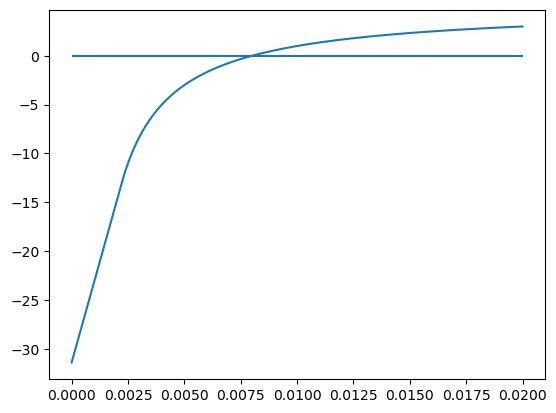

In [23]:
plt.plot(np.linspace(0.,0.02,10000),min_m2min)
plt.hlines(0.,0.,0.02)

Text(0, 0.5, 'zeta')

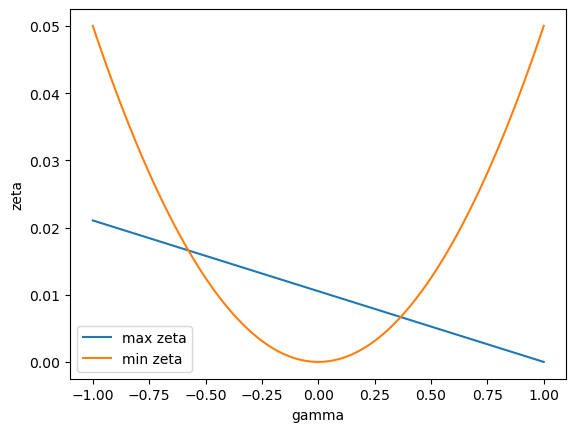

In [7]:
gamma = np.linspace(-1,1,100)
mmax=100.
mmin=5.

zeta_max = (1.-gamma)/(mmax-mmin)
zeta_min = gamma**2/(4*mmin)

zeta_min2 = ((-gamma)/(mmax-mmin))-(mmin/((mmax-mmin)**2))

plt.plot(gamma, zeta_max, label='max zeta')
plt.plot(gamma, zeta_min , label='min zeta')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('zeta')
#plt.plot(gamma, zeta_min2)


In [8]:
gamma_min = -2*(mmin**0.5)/(mmax**0.5-mmin**0.5)
gamma_max = 2*(mmin**0.5)/(mmax**0.5+mmin**0.5)

In [9]:
gamma_min

-0.5760143110525874

In [10]:
gamma_max

0.36548799526311365